In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

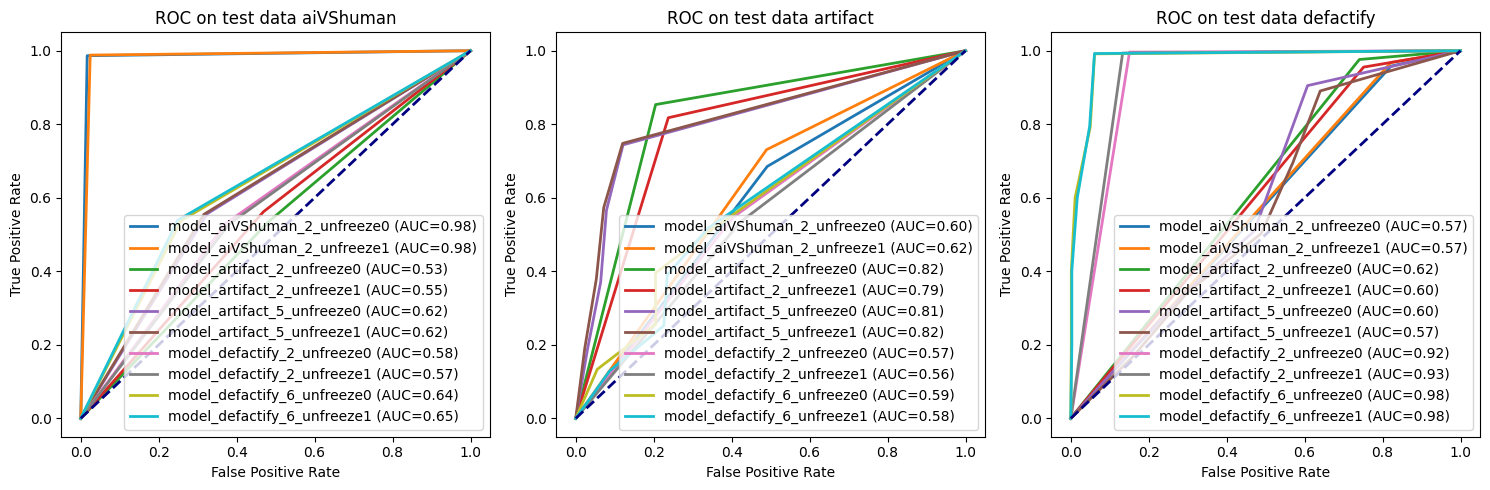


Performance Metrics:
      Full Model Name     Model  Classes  Unfreeze   Test Dataset  ROC-AUC  Precision@Recall≥0.3  Precision@Recall≥0.5  Precision@Recall≥0.7
aiVShuman_2_unfreeze0 aiVShuman        2         0 data_aiVShuman 0.984995              0.983488              0.983488              0.983488
aiVShuman_2_unfreeze1 aiVShuman        2         1 data_aiVShuman 0.981943              0.975482              0.975482              0.975482
 artifact_2_unfreeze0  artifact        2         0 data_aiVShuman 0.526518              0.371779              0.371779              0.347717
 artifact_2_unfreeze1  artifact        2         1 data_aiVShuman 0.546599              0.377283              0.377283              0.335710
 artifact_5_unfreeze0  artifact        5         0 data_aiVShuman 0.615945              0.839630              0.839630              0.753471
 artifact_5_unfreeze1  artifact        5         1 data_aiVShuman 0.619436              0.854141              0.854141              

In [4]:
results_path = "../results/clip_mlp_models"
test_datasets = sorted(os.listdir(os.path.join(results_path, sorted(os.listdir(results_path))[0])))

metrics_data = []

fig, axes = plt.subplots(1, len(test_datasets), figsize=(5*len(test_datasets), 5))

for idx, test_data in enumerate(test_datasets):
    ax = axes[idx]
    ax.set_title(f"ROC on test {test_data.replace('_', ' ')}")
    
    for result_folder in sorted(os.listdir(results_path)):
        predictions = pd.read_csv(os.path.join(results_path, result_folder, test_data, "predictions.csv"))
        scores = predictions["label"].values
        y_true = predictions["predicted_raw"].values
        y_true = [0 if y == 0 else 1 for y in y_true]
        
        fpr, tpr, thresholds = roc_curve(y_true, scores)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{result_folder} (AUC={roc_auc:.2f})')
        
        precision, recall, _ = precision_recall_curve(y_true, scores)
        
        def get_precision_at_recall(recall_level):
            mask = recall >= recall_level
            if any(mask):
                return np.max(precision[mask])
            return np.nan
        
        prec_at_recall_03 = get_precision_at_recall(0.3)
        prec_at_recall_05 = get_precision_at_recall(0.5)
        prec_at_recall_07 = get_precision_at_recall(0.7)
        
        model_parts = result_folder.split('_')
        model_name = model_parts[1]
        num_classes = int(model_parts[2]) if len(model_parts) > 1 else 2
        unfreeze = int(model_parts[-1][-1]) if 'unfreeze' in result_folder else 0
        
        metrics_data.append({
            'Model': model_name,
            'Classes': num_classes,
            'Unfreeze': unfreeze,
            'Test Dataset': test_data,
            'ROC-AUC': roc_auc,
            'Precision@Recall≥0.3': prec_at_recall_03,
            'Precision@Recall≥0.5': prec_at_recall_05,
            'Precision@Recall≥0.7': prec_at_recall_07
        })
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

metrics_df = pd.DataFrame(metrics_data)

metrics_df['Full Model Name'] = metrics_df.apply(
    lambda row: f"{row['Model']}_{row['Classes']}_unfreeze{row['Unfreeze']}", axis=1
)

metrics_df = metrics_df[[
    'Full Model Name', 'Model', 'Classes', 'Unfreeze', 'Test Dataset',
    'ROC-AUC', 'Precision@Recall≥0.3', 'Precision@Recall≥0.5', 'Precision@Recall≥0.7'
]]

plt.tight_layout()
# plt.savefig(os.path.join(results_path, "all_roc_curves.png"), dpi=300, bbox_inches='tight')
plt.show()

# metrics_df.to_csv(os.path.join(results_path, "performance_metrics_detailed.csv"), index=False)

# Выводим таблицу в консоль для проверки
print("\nPerformance Metrics:")
print(metrics_df.to_string(index=False))

# Дополнительно: создаем сводную таблицу с лучшими моделями для каждого тестового набора
# best_models = metrics_df.loc[metrics_df.groupby('Test Dataset')['ROC-AUC'].idxmax()]
# print("\nBest Models for Each Test Dataset:")
# print(best_models.to_string(index=False))